In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from bs4 import BeautifulSoup 
import re
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

        
import warnings
warnings.filterwarnings("ignore")

# Load tha datasets

In [55]:
# Load the imbd dataset and remove the columns that are not useful.
imdb = pd.read_csv("data/imdb-review-dataset/imdb_master.csv", encoding="latin-1")
imdb.drop(["Unnamed: 0", "type", "file"], axis=1, inplace=True)
imdb.columns = ["review", "sentiment"]

#### Remove the rows where sentiment is 'unsup'. 

In [56]:
imdb['sentiment'].unique(), imdb['sentiment'].value_counts()

(array(['neg', 'pos', 'unsup'], dtype=object),
 unsup    50000
 neg      25000
 pos      25000
 Name: sentiment, dtype: int64)

In [57]:
imdb = imdb[imdb.sentiment != 'unsup']
# Change sentiment column into integer with help of map.
imdb['sentiment'] = imdb['sentiment'].map({'pos': 1, 'neg': 0})
imdb.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [58]:
train = pd.read_csv("data/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", compression='zip', header=0, delimiter="\t", quoting=3)
train.drop('id', axis=1, inplace=True)

In [59]:
train.head(), train.size

(   sentiment                                             review
 0          1  "With all this stuff going down at the moment ...
 1          1  "\"The Classic War of the Worlds\" by Timothy ...
 2          0  "The film starts with a manager (Nicholas Bell...
 3          0  "It must be assumed that those who praised thi...
 4          1  "Superbly trashy and wondrously unpretentious ...,
 50000)

In [60]:
# Merge two dataset into one.
train_df = pd.concat([train, imdb]).reset_index(drop=True)
train_df.shape
del train
del imdb

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75000 non-null  int64 
 1   review     75000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [62]:
train_df.shape

(75000, 2)

# Clean the reviews

In [63]:
def review_to_words(review):
    
    #remove html from review
    review_text = BeautifulSoup(review).get_text()

    #remove all non-letters(any character that IS NOT a-z OR A-Z) and convert it into list
    words = re.sub("[^a-z A-Z]", "", review_text).lower().split()
    
    stops = set(stopwords.words('english'))
    
    #remove stop words from list
    meaningful_words = [w for w in words if not w in stops]
    
    #convert list into review
    return(" ".join(meaningful_words))

In [64]:
length_train = train_df['review'].size

clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
print ("Cleaning and parsing the training set movie reviews...\n")
for i in range(0, length_train):
    # If the index is evenly divisible by 10000, print a message
    if((i+1) % 10000 == 0):
        print ("Review %d of %d\n" % ( i+1, length_train))                                                                 
    clean_train_reviews.append(review_to_words(train_df["review"][i]))
print("Done")

Cleaning and parsing the training set movie reviews...

Review 10000 of 75000

Review 20000 of 75000

Review 30000 of 75000

Review 40000 of 75000

Review 50000 of 75000

Review 60000 of 75000

Review 70000 of 75000

Done


In [65]:
# Bag of Words

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

# Select the top 6000 features.
vectorizer = CountVectorizer(max_features = 6000)

train_data_features = vectorizer.fit_transform(clean_train_reviews)

train_data_features = train_data_features.toarray()
print ("Done")

Done


# Visualization of common words.

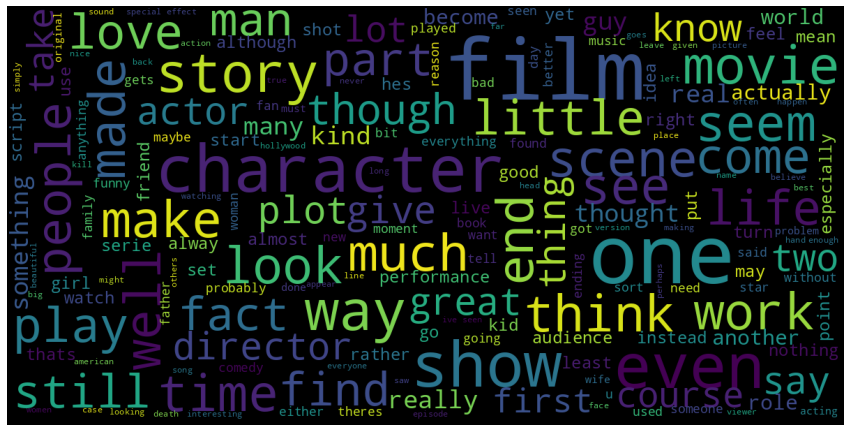

In [67]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(clean_train_reviews)

In [68]:
train_data_features.shape

(75000, 6000)

## Split the data into train and test set.

In [69]:
#splitting dataset into training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_data_features,train_df["sentiment"],test_size=0.2,random_state=0)
print("Splitting Done")

Splitting Done


In [70]:
del clean_train_reviews
del train_data_features

# Train Random Forest Classifier on Bag of words.

In [71]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100)

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
preds = rfc.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix, classification_report
#checking accuracy score
accuracy = accuracy_score(y_test,preds)
print(accuracy)
f1 = f1_score(y_test,preds)
print(f1)

0.9323333333333333
0.9320115212003484


In [74]:
cm=confusion_matrix(y_test,preds)
cm

array([[7028,  455],
       [ 560, 6957]])

In [75]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7483
           1       0.94      0.93      0.93      7517

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000

